# Bowerbird Agents Model

## Rachel and Julia 
Key
Notes- Parameters contain underscores, while functions don't

SB: Stay at bower

FG: Foraging

MT: Maraud travel (travel to rival's bower)

MA: Maraud action (destroy bower if absent, have antagonistic interaction in present)

MR: Maraud return (return to own bower)

RB: Repair own bower

MT_vs_FG: the probability of next transition away from SB being to MT (otherwise it would be to FG)

a=-1: denotes a staying at bower action on ticket

a=-2: denotes a foraging action on ticket

a=-3: denotes a female visiting action on a ticket

a=-4: denotes travel to another male's bower

a=-5: denotes marauding of another male's bower

a=-6: denotes returning from another male's bower

a=-7: denotes a bower repair action on a ticket

target: the male an action is preformed on. For maurading, the target is the bird under potential attack. For mating, target is male being mated with. For other activities other then maurading and mating, owner and target are the same.

owner: The male or female actively performing an action. For mating, the female is the owner. For all other activities, the owner is male.

networkwriter: generates network where everybird is connected
addtotimeline: adds tickets to timeline

travel_times_linear_p: generates a matrix that contains the probabilities of travelling to a given a bower 
if the relationship between distance and travel preference is linear

improb: The probability of traveling improb_distance or less

improb_distance: The distance at which there is only a (1-improb)% chance of choosing to travel

lamb: lambda calculated by solving improb=1-numpy.exp(-lamb*improb_distance)

bower_states: options are 1 (bower intact) and 0 (bower destroyed-will never be the case when all guarders) and another value for time that mating will end (assuming mating is happening)

male_states: options are [leave_time, leave_action, SB_timeholder] (male present at bower) and 0 (male absent from bower)

fitness_states: keeps track of number of matings a given male has had

t: time

males: total number of male bowerbirds in the network

male_dist: the males by males matrix with distances between each male

tau: Length of time an activity takes. If a foraging ticket has a tau of 0.5 and occurs at t=1, then the bird is foraging for 30 minutes, at which point a SB activity will start (at t=1.5).

t_court: the amount of time it takes a female to court+mate with a male, generated from a normal distribution
not_maraud_time: the time added to SB by guarders

In [1]:
import math
import random
import numpy 
import matplotlib.pyplot as plt

In [2]:
# Global Parameters:
t = 0.0 #start at time 0
t_max = 12 #2 months in hrs (assume no nights so 12 hr = 1 day)
timeholder = 0 
timeline = [] #initialize the timeline
discards = [] #where we put the old version of tickets that get over-written/moved
#We've moved away from using these params with expovariate (how we handle FV is still TBD)
#So THE BELOW 3 SHOULD BE COMMENTED OUT (but rn we don't want the handler funcs to yell at us)
FV_param = [0, t_max] #5days, tmax/3 #0.2 #males/0.19 #totally random
FG_param = 3 #larger values lead to foraging ending earlier, because taus are smaller
SB_param = 1.5 #larger values lead to bowerstay ending earlier, because taus are smaller
RB_param = 6 #made up -- takes 30mins (every time -- no distribution) to repair bower
MA_param = 0.1 #made up -- takes 6mins (every time -- no distribution) to maraud bower
MT_vs_FG = 0.1 #.05 originally #compared 20 feedings/day to .1 maraudings/hr
males = 100
bower_states = [0] * males
male_states = [0] * males #start at foraging now
mating_states = [0] * males
fitness_states = numpy.array([0] * males)
success_rate = 1
success_times = [] #going to change this to be a vector of times when the female leaves (at this point, sucessful mating has occured)
recents_list = []
max_visits = 6 #STEEEEVEEEE
bird_speed = 12 * 3600 #m/hr (12m/s)
d = 1000.0
FperM = 3 #number of sexually mature females per sexually mature males in a bowerbird population
num_sims = 1
not_maraud_time = 0.15

In [3]:
def ticketgenerator(tau,t, o, a, targ, t2):
    ticket = {
        'tau': tau, #how long the activity lasts
        'time': t, #time at which the activity starts
        'owner': o, #who is doing the activity (could be a female if action=-3)
        'action': a, #which activity (see key)
        'target': targ, #target of the activity (owner=target unless action=-3,-4,-5, or -6)
        'origin': t2 #the time of the ticket that generated this one
    }
    return ticket

In [4]:
#adds new tickets to timeline -- Stefano, any more efficient suggestions for keeping timeline in order?
def addtotimeline(tic): #A CHANGE
    if not timeline:
        timeline.append(tic)
    else:
        ind=len(timeline)-1
        end=0
        while (tic['time']<timeline[ind]['time'] and end==0): #moves backwards until it finds where to place the ticket based on the listed times
            ind=ind-1 
            if(ind<0):
                end=1
        ind=ind+1
        timeline.insert(ind, tic)

In [5]:
# creation of the environment

def envgenerator(males, x_dim, y_dim):
    Xs = numpy.random.rand(males) * x_dim
    Ys = numpy.random.rand(males) * y_dim
    return [Xs,Ys]

def dists(xy, bird_speed):
    male_dist = numpy.zeros(males * males).reshape((males, males))
    travel_times = numpy.zeros(males * males).reshape((males, males))
    for i in range(males):
        for j in range(i + 1, males):
            dist = math.sqrt((xy[0][j] - xy[0][i]) ** 2 + (xy[1][j] - xy[1][i]) ** 2)
            travel = dist / bird_speed
            male_dist[j][i] = dist
            male_dist[i][j] = dist
            travel_times[j][i] = travel
            travel_times[i][j] = travel
    return [male_dist,travel_times]

# the probability of choosing a neighbor at distance x is proportional to exp(-\lambda x)
# choose lambda such that 99% of the mass is before 800 meters
improb = 0.99
improb_distance = 800
lamb = -math.log(1 - improb) / improb_distance

#will write female preference based on cumulative exponential decay (lambda=.00576)
def preferences(male_dist, males, lamb):
    # compute exponential of each coefficient
    visit_preferences = numpy.exp(-lamb * male_dist)
    # remove the identity matrix (exp(0) = 1)
    visit_preferences = visit_preferences - numpy.eye(males)
    # make rows sum to one
    visit_preferences = (visit_preferences.transpose() / numpy.sum(visit_preferences, 1)).transpose()
    return visit_preferences

In [6]:
# function for determining the next time based on our rate parameters
def nexttau(action, ow, targ, new_t, new_tau=-1):
    while new_tau<=0:
        switcher = { #NOTE: used abs
            -1: numpy.random.normal(loc=.1583, scale=.09755, size=1)[0], #choose when to leave bower (generate a tau for bower stay)
            -2: numpy.random.gamma(shape=1.5, scale=5, size=1)[0]/60, #choose when to stop foraging (generate a tau for foraging)
            -3: numpy.random.uniform(FV_param[0], FV_param[1]), #FV_param... totally arbitrary so we should think about it
            -4: travel_times[ow][targ],
            -5: MA_param, #in the future we'll do something with it
            -6: travel_times[targ][ow],
            -7: 1 / (1-MT_vs_FG) * (numpy.random.normal(loc=.1583, scale=.09755, size=1)[0]) #rescale SB_param because no marauding can occur from RB (want FG times to be comparable)
        }
        new_tau=switcher.get(action)
    future_t=new_tau+new_t #time on future ticket will be the current time plus the tau
    if future_t>t_max: 
        new_tau=new_tau-(future_t-t_max) #this ensures that the tau+t won't exceed t_max
    return new_tau

def futurebuilder(old_tic, new_ac, new_targ, new_tau=-1):
    old_t=old_tic['time']
    new_t=old_t+old_tic['tau']
    new_tic={}
    if new_t<t_max:
        ow=old_tic['owner']
        new_tic=ticketgenerator(nexttau(new_ac, ow, new_targ, new_t), new_t, ow, new_ac, new_targ, old_t)
        addtotimeline(new_tic)
    return new_tic
    


#Stay at bower ticket handler. Ticket is read, and male state changes to at bower. 
#The tickethandler can generate then generate a repair bower, foraging, or maurad travel ticket.
def SBtickethandler(SB_tic):
    ow=SB_tic['owner'] #the owner of the ticket is the male bird from the stay at bower ticket
    if bower_states[ow]<0: #if male returns to a destroyed bower, must repair it
        SB_tic['tau']=0
        timeline[timeholder]=SB_tic
        new_tic=futurebuilder(SB_tic, -7, ow) #generate a new tau and ticket with repair bower action, and add it to the timeline
    else: #if the bower is intact
        decider=random.random()
        if decider<MT_vs_FG: #transition to MT
            if strategy_states[ow]==0: #if the male is a guarder
                new_tau=SB_tic['tau']+not_maraud_time
                future_t=new_tau+SB_tic['time'] #time on future ticket will be the current time plus the tau
                if future_t>t_max: 
                    new_tau=(new_tau-(future_t-t_max)) #this ensures that the tau+t won't exceed t_max
                SB_tic['tau']=new_tau
                timeline[timeholder]=SB_tic
                new_tic=futurebuilder(SB_tic, -2, ow) #generate a new tau and ticket with foraging action, and add it to the timeline
            else:
                targ=numpy.random.choice(list(range(males)), p=visit_preferences[ow]) #choosing the male to maurad based on visit preferences
                new_tic=futurebuilder(SB_tic, -4, targ) #generate a new tau and ticket with maurad travel action, and add it to the timeline
        else:
            new_tic=futurebuilder(SB_tic, -2, ow) #generate a new tau and ticket with foraging action, and add it to the timeline
    if new_tic=={}: 
        male_states[ow]=[t_max, -10, timeholder] #still need to show male is at bower, but -10 action is gibberish (since male won't leave bower before tmax)
    else: 
        if new_tic['action']==-7: #If the next action will be repair bower
            male_states[ow]=1 #A CHANGE: we don't know when male will leave bower but we need to state he is at bower now
        else:
            male_states[ow]=[new_tic['time'],new_tic['action'],timeholder]
            
            
            
#Foraging ticket handler. Ticket read, and male state changes to no longer at bower. Generates a stay at bower ticket.
def FGtickethandler(FG_tic):
    ow=FG_tic['owner'] 
    t=FG_tic['time']
    ta=FG_tic['tau']
    #print(male_states[ow])
    if t==0: #in this case male_states[ow]=0
        #male_states[ow]=0 #male is no longer at bower (this for if males start at SB)
        futurebuilder(FG_tic,-1,ow)
    elif bower_states[ow]<0:
        male_states[ow]=0
        futurebuilder(FG_tic,-1,ow)
    elif math.isclose(male_states[ow][0],t, rel_tol=0, abs_tol=.0000001)==0:
        discards.append(FG_tic)
        timeline[timeholder]['action']=abs(FG_tic['action']) 
    else:
        male_states[ow]=0 #male is no longer at bower
        futurebuilder(FG_tic, -1, ow)
        
#Maurad travel ticket handler. Male state changes to no longer at bower, and generates a maurad action ticket.
def MTtickethandler(MT_tic):
    ow=MT_tic['owner']
    targ=MT_tic['target']
    t=MT_tic['time']
    if math.isclose(male_states[ow][0],t, rel_tol=0, abs_tol=.0000001)==0:
        discards.append(MT_tic)
        timeline[timeholder]['action']=abs(MT_tic['action']) #A CHANGE
        #print("malestates is {:f} while tictime is {:f}".format(male_states[ow][0], t))
    else:
        male_states[ow]=0 #male is no longer at his bower
        futurebuilder(MT_tic, -5, targ)

#Maurad action ticket handler. The bower destruction occurs if the targeted bower's owner is absent and the bower is intact. 
#Otherwise, the tau for this ticket is zero (bird immediately turns atruncate). This ticket handler then generates a
#maurad return ticket.
def MAtickethandler(MA_tic):
    targ=MA_tic['target']
    if male_states[targ]==0 and bower_states[targ]==0: #if the bower is intact and its owner is absent
        bower_states[targ]=-RB_param #the time it will take to be repaired -- can later be pulled from a dist if we want
    else: #in all other cases bowerbird immediately leaves
        MA_tic['tau']=0 #COMMENT! Changing tau for this ticket as we read it bc stay is cut short by bower owner's presence
    futurebuilder(MA_tic, -6, targ)

    
#Repair bower / maurad return ticket handler. This ticket handler then generates a ticket for stay at bower.
def RBtickethandler(RB_tic):
    ow = RB_tic['owner']
    tau = RB_tic['tau']
    if bower_states[ow]+tau>=0:
        oversized_tau = tau
        #change the tau on RB_tic to be -1*bower_states[ow]
        tau = -1*bower_states[ow]
        RB_tic['tau'] = tau 
        timeline[timeholder]=RB_tic
        #generate and add TR_tic happening as soon as bower is repaired
        #THIS IS WHERE THE CODE FOR THAT GOES...
        #WHAT WE DID BEFORE: make a SB_ticwith tau of (bower_states[ow]+tau) (where tau is the old tau)
        futurebuilder(RB_tic, -1, ow, new_tau=bower_states[ow]+oversized_tau)
        #futurebuilder(RB_tic, -2, ow) # , new_tau=bower_states[ow]+oversized_tau) (see above)
    else:
        futurebuilder(RB_tic, -2, ow) 
    #update ow's bower state based on time spent repairing
    bower_states[ow]=bower_states[ow]+tau
    
    
#Maurad return ticket handler. This ticket handler then generates a ticket for stay at bower.
def MRtickethandler(MR_tic):
    ow=MR_tic['owner']
    futurebuilder(MR_tic, -1, ow)

       
#Female visitation ticket handler. Females visit and mate with males if the following conditions are met: 
#(1) The male is at the bower, (2) the bower is intact, and (3) no other female is present.
#If not,the female keeps this male on her recents list, and travels to additional males with probabilities based on a preference matrix,
#If the female finds no eligeble males but her recents list is full, a longer tau is generated. 
#Her short term memory is cleared (the recents list), and she can try any of the males again. This continues 
#until she mates succusfully. Then, the male tickets for stay at bower are extended until the female leaves. 
def FVtickethandler(FV_tic, recents_list):
    targ=FV_tic['target']
    ow=FV_tic['owner']
    t=FV_tic['time']
    recents_list=d["rl{0}".format(ow)]
    r=random.random() #generate this to decide whether mating happens if other conditions are met
    if bower_states[targ]==0 and male_states[targ]!=0 and r<success_rate and t>mating_states[targ]: #if the bower is intact and the male is present
        tau_court= 0.25 #numpy.random.normal(loc=.1504, scale=.0102, size=1)[0]
        timeline[timeholder]['tau']=tau_court #if mating is successful, then it takes .25hrs #MAKE IT NOT EXCEED t_max
        t_court_end=t+tau_court
        mating_states[targ]=t_court_end
        fitness_states[targ]=fitness_states[targ]+1 #assumption: female always mates if bower is intact and male present
        success_times.append(t_court_end) #this is the time at which the mating finishes (not starts, tho it could be)       
        if male_states[targ][0]<t_court_end:
            SB_tic=timeline[male_states[targ][2]] #this SB ticket has the wrong tau -- we must modify the timeline
            SB_tic['tau']=t_court_end-male_states[targ][0]+SB_tic['tau'] #the new tau is generated by tacking on the extension of SB due to FV
            timeline[male_states[targ][2]]['tau']=SB_tic['tau'] #modify the ticket on the timeline itself
            if SB_tic['tau']>50.0:
                print("ERROR at time {:f} with male {:d}".format(t, targ))
                print("t_court_end: {:f}".format(t_court_end))
                print("og time: {:f}".format(male_states[targ][0]))            
            if male_states[targ][1]==-4: #if a MT ticket, generate a new tau and new_targ (individual to be marauded by targ)
                new_targ=numpy.random.choice(list(range(males)), p=visit_preferences[targ]) #choosing the male to maurad based on visit preferences
            else: #if a FG ticket, generate a new tau and set new_targ to targ
                new_targ=targ #targ=ow (or in this case new_targ=targ) when it's an FG_tic
            futurebuilder(SB_tic, male_states[targ][1], new_targ)
            male_states[targ][0]=t_court_end #now change male states so that the leave_time is accurate 
    else: #if female does not successfully mate
        #HEY!!: tau is court time not time until next FV... consider changing to use futurebuilder
        recents_list.append(targ)
        if len(recents_list)==min(max_visits, males): #if she's already visited her max # of males and not mated, reset recents and use nexttau
            recents_list=[]
            new_FV_targ=numpy.random.choice(list(range(males)), p=visit_preferences[targ])
            new_FV_time=t+12 #she goes to another male after waiting some time (nexttau), courting takes no time
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(0,new_FV_time, ow, -3, new_FV_targ, t)
                addtotimeline(new_FV_tic)
        else: #otherwise find a male not in recents and use travel_times
            new_FV_targ=-1 #just so that the code goes into the while loop the first iteration
            while(new_FV_targ in recents_list or new_FV_targ==-1):
                new_FV_targ=numpy.random.choice(list(range(males)), p=visit_preferences[targ]) #choose a male based on preference (a function of distance)
            new_FV_time=t+travel_times[targ][new_FV_targ] #she goes directly to this male
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(0,new_FV_time, ow, -3, new_FV_targ, t)
                addtotimeline(new_FV_tic)
    return recents_list

dist 0.000000/1.000000
prop 0.000000/1.000000
sim 0.000000


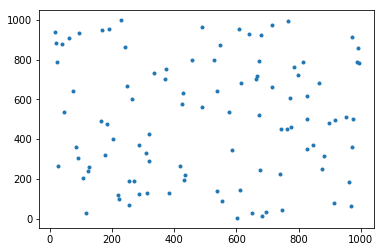

In [7]:




dist_vec=[1000]#, 500, 750, 1000]
prop_vec=[1] #numpy.arange(5, 100, 20)*.01


maraud_fit_dist=[[0.0]*len(prop_vec)]*len(dist_vec)
sd_maraud_fit_dist=[[0.0]*len(prop_vec)]*len(dist_vec)
#guard_fit_dist=[[0.0]*len(prop_vec)]*len(dist_vec)
for x in range(len(dist_vec)):
    print("dist {:f}/{:f}".format(x, len(dist_vec)))
    maraud_fit_prop=[0.0]*len(prop_vec)
    sd_maraud_fit_prop=[0.0]*len(prop_vec)
    #guard_fit_prop=[0.0]*len(prop_vec)
    for y in range(len(prop_vec)):
        print("prop {:f}/{:f}".format(y, len(prop_vec)))
        prop_marauder=prop_vec[y] #proportion of marauders in population #put w parameters later
        marauder_fitness=[[0.0]*males]*num_sims
        for j in range(num_sims): #for each simulation...
            print("sim {:f}".format(j))
            #NEW CODE!!!!
            x_dim=dist_vec[x]
            y_dim=dist_vec[x]
            coordinates=envgenerator(males, x_dim, y_dim)
            plt.figure()
            plt.plot(coordinates[0],coordinates[1],'.')
            mats=dists(coordinates,bird_speed) #these are the male distance and travel time mats
            travel_times=mats[1]
            male_dist=mats[0]
            visit_preferences=preferences(male_dist, males, lamb)
            strategy_states=numpy.array([0]*males) #initialize strategy states, 0=guarder, 1 will = marauder
            marauder_inds=numpy.random.choice(list(range(males)), size=int(males*prop_marauder), replace=False) #choose the marauders
            #for z in range(len(marauder_inds)):
            #marauder_inds[z]=int(marauder_inds)
            strategy_states[marauder_inds]=1 #set these individuals to be marauders 
            t=0.0 #start at time 0
            timeholder=0
            timeline=[] #initialize the timeline
            discards=[] #where we put the old version of tickets that get over-written/moved
            bower_states=[0]*males
            male_states=[0]*males #start at foraging now
            mating_states=[0]*males
            fitness_states=numpy.array([0]*males)
            recents_list=[]
            #Seed the timeline
            d={}
            #changed so they start out foraging not SB!
            for i in range(males):
                init_FG_time=t+nexttau(-2, i, i, 0)
                init_FG_tic=ticketgenerator(init_FG_time-t, t, i, -2, i, {})
                addtotimeline(init_FG_tic)
            #the logic with ts and taus is not parallel to all other ticket types, but it seems to work... maybe change later    
#             for i in range(int(FperM*males)): #FperM*males
#                 first_male=random.choice(list(range(males))) #The lucky bowerbird that is chosen by the female first
#                 first_female_time=numpy.random.uniform(FV_param[0], FV_param[1]) #determine the time when the first female arrives
#                 first_female_tic=ticketgenerator(0,first_female_time, i, -3, first_male, {}) #first female ticket
#                 addtotimeline(first_female_tic)
#                 d["rl{0}".format(i)]=[]
            #read tickets, generate more tickets, and move through the timeline until t_max is reached
            while t<t_max:
                if timeholder>(len(timeline)-1): #if timeholder exceeds max timeline index
                    break
                next_tic=timeline[timeholder] #look at the ticket corresponding to where we are on the timeline
                action=next_tic['action']
                ow=next_tic['owner']
                if action==-1:
                    SBtickethandler(next_tic)
                elif action==-2:
                    FGtickethandler(next_tic)
                elif action==-3:
                    d["rl{0}".format(ow)]=FVtickethandler(next_tic, d["rl{0}".format(ow)])
                elif action==-4:
                    MTtickethandler(next_tic)
                elif action==-5:
                    MAtickethandler(next_tic)
                elif action==-6:
                    MRtickethandler(next_tic) 
                else:
                    RBtickethandler(next_tic)
                t=next_tic['time'] #new time based on the ticket we just read
                timeholder=timeholder+1 #increment timeholder 
                #fitness_states=numpy.ndarray(fitness_states)
            marauder_fitness[j]=numpy.mean(fitness_states[marauder_inds])
            #ia = numpy.indices(fitness_states.shape)
            #not_indices = numpy.setxor1d(ia, marauder_inds)
            #guarder_fitness[j]=numpy.mean(avsfs[not_indices])
        maraud_fit_prop[y]=numpy.mean(marauder_fitness)
        sd_maraud_fit_prop[y]=numpy.std(marauder_fitness)
        #guard_fit_prop[y]=numpy.mean(guarder_fitness)
    maraud_fit_dist[x]=maraud_fit_prop
    sd_maraud_fit_dist[x]=sd_maraud_fit_prop
    #guard_fit_dist[x]=guard_fit_prop
    
    



        

In [8]:
d={}


for i in range(males):
    d["tl{0}".format(i)]=[]
for j in range(len(timeline[0:timeholder])):
    #for i in range(males):
     #   if timeline[j]['owner']==i:
    if timeline[j]['action']==-3:
        d["tl{0}".format(timeline[j]['target'])].append(timeline[j])  
    else:
        d["tl{0}".format(timeline[j]['owner'])].append(timeline[j])

print("tl0----")
print(d["tl0"])
#print("tl1----")
#print(d["tl1"])
#print("tl2----")
#print(d["tl2"])
#print("tl3----")
#print(d["tl3"])

tl0----
[{'tau': 0.13919531379684552, 'time': 0.0, 'owner': 0, 'action': -2, 'target': 0, 'origin': {}}, {'tau': 0.10452929753074354, 'time': 0.13919531379684552, 'owner': 0, 'action': -1, 'target': 0, 'origin': 0.0}, {'tau': 0.022702168656170436, 'time': 0.24372461132758905, 'owner': 0, 'action': -2, 'target': 0, 'origin': 0.13919531379684552}, {'tau': 0.2107626231345506, 'time': 0.26642677998375947, 'owner': 0, 'action': -1, 'target': 0, 'origin': 0.24372461132758905}, {'tau': 0.003241099069465676, 'time': 0.47718940311831004, 'owner': 0, 'action': -4, 'target': 33, 'origin': 0.26642677998375947}, {'tau': 0, 'time': 0.4804305021877757, 'owner': 0, 'action': -5, 'target': 33, 'origin': 0.47718940311831004}, {'tau': 0.003241099069465676, 'time': 0.4804305021877757, 'owner': 0, 'action': -6, 'target': 33, 'origin': 0.4804305021877757}, {'tau': 0.09887464979134722, 'time': 0.4836716012572414, 'owner': 0, 'action': -1, 'target': 0, 'origin': 0.4804305021877757}, {'tau': 0.1319783829300168

In [9]:
acc=0
all_su=[0]*males
all_mar_props=[0]*males
all_probs=[[0]*4]*males
print(all_probs)
for i in range(males):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[]
    accSB=0
    accFG=0
    accM=0
    accRB=0
    allacc=0
    FV_list=[]
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            if tl[j]['action']<0:
                ta.append(tl[j]['tau'])
            #print("time according to taus is {:f}".format(allacc))
            #print("time according to tickets is {:f}".format(tl[j]['time']))
                allacc+=tl[j]['tau']
            if tl[j]['action']==-1:
                accSB=accSB+tl[j]['tau']
                #print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
            elif tl[j]['action']==-2:
                accFG=accFG+tl[j]['tau']
                #print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
            elif tl[j]['action']==-7:
                accRB=accRB+tl[j]['tau']
                #print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
            elif tl[j]['action']==-4 or tl[j]['action']==-5 or tl[j]['action']==-6:
                accM=accM+tl[j]['tau']  
                #print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
                acc=acc+1
        else:
            #print("FV")
            FV_list.append(tl[j])
    d["taus{0}".format(i)]=ta
    su=sum([accSB/t_max, accM/t_max, accFG/t_max, accRB/t_max])
    all_su[i]=su
    print("DOES IT ADD UP: {:f}".format(su))
    print("Bird {:d}'s % time at bower is {:f}".format(i, accSB/t_max)) 
    print("Bird {:d}'s % time marauding is {:f}".format(i, accM/t_max)) 
    print("Bird {:d}'s % time foraging is {:f}".format(i, accFG/t_max)) 
    print("Bird {:d}'s % time repairing bower is {:f}".format(i, accRB/t_max)) 
    print("Bird {:d}'s separate accs sum to {:f}".format(i,(accSB+accM+accFG+accRB)))
    print("Bird {:d}'s allacc is {:f}".format(i,allacc))
    
    all_probs[i]=[accSB/t_max, accFG/t_max, accRB/t_max, accM/t_max]
    #all_probs[i][1]=accFG/t_max
    #all_probs[i][2]=accM/t_max
    #all_probs[i][3]=accRB/t_max
    all_mar_props[i]=accM/t_max

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
# fig, ax=plt.subplots()
# for x in range(len(dist_vec)): 
#     series=maraud_fit_dist[x]
#     ax.plot(prop_vec, series, linestyle='-', marker='o', label="d={:f}".format(dist_vec[x]))
#     #plt.errorbar()
# legend=ax.legend(loc=1)
# plt.xlabel("Proportion marauders")
# plt.ylabel("Average marauder mating success")
# plt.axhline(y=3, ls=':', color='black')
# plt.show() 
    

In [11]:
# #NEW CODE
# def malemaker(identity, fitness=0, state=-1, bower_state=1, cumulative_time=[0]*7, behavior, bower_position, maraud_preferences, next_FG):
#     male_agent=
#     {'identity': identity
#      'fitness':fitness,
#      'state': state,
#      'bower_state': bower_state,
#      'cumulative_time':cumulative_time,
#      'behavior': behavior,
#      'bower_position': bower_position,
#      'maraud_preferences': maraud_preferences,
#      'next_FG': next_FG #the index of the n
#     }
#     return male_agent
# #def generatenextFGlist():
# #^to be written later
# from sortedcontainers import SortedDict
# male_agents=[]

# for i in range(males):
#     identity=i
#     behavior=numpy.random.uniform() #THIS WILL MAYBE CHANGE -- just for now (later we want to toggle btwn binary and continuous)
#     bower_position=[coordinates[0][i], coordinates[1][i]]
#     maraud_preferences=visit_preferences[i]
#     next_FG=generatenextFGlist() #always check first entry, once we go foraging we pop a time off the front of the list
#     male_agents[i]=malemaker(identity=identity behavior=behavior, bower_position=bower_position, maraud_preferences=maraud_preferences, next_FG=next_FG)

# #key_trait=0 #using identity for now

# #s_males=sorted(iter(males))

# #for key in sorted(iter(males)):
# #    print(key)
# #    print(males[key])



In [12]:
# mydict = {'carl':40,
#           'alan':2,
#           'bob':1,
#           'danny':3}

# for key in sorted(iter(mydict)):
#     print(key)
#     print(mydict[key])
    
    


In [13]:
# sorted(iter(mydict))

In [14]:
# old_tic=ticketgenerator(0, 1, 2, -1, 2, {})
# timeline=[old_tic]
# futurebuilder(old_tic, -2, 2)
# print(timeline)
# futurebuilder(old_tic, -2, 2, new_tau=1)
# print(timeline)

In [15]:
print(male_states)

[[12, -10, 10082], 0, 1, 1, 1, [12, -10, 10124], [12, -10, 10020], 0, [12, -10, 10009], 0, 0, 1, 0, [12, -10, 10128], 0, 0, [12, -10, 10139], [12, -10, 10175], 0, [12, -10, 10153], 0, [12, -10, 10102], [12, -10, 9923], 0, 1, 1, 0, 0, 1, [12, -10, 10161], 0, 0, [12, -10, 10141], 1, [12, -10, 10117], [12, -10, 10112], 1, 1, 0, 0, 1, [12, -10, 10143], [12, -10, 9844], 0, 0, [12, -10, 10116], [12, -10, 9953], 1, 1, [12, -10, 10162], 1, 1, 1, [12, -10, 10157], [12, -10, 10122], 0, [12, -10, 10039], [12, -10, 10152], 1, 1, [12, -10, 10047], 0, 1, 1, [12, -10, 9991], 0, 1, 0, [12, -10, 10048], 0, [12, -10, 10136], 0, [12, -10, 10036], [12, -10, 10061], 0, 0, 1, [12, -10, 10067], 1, [12, -10, 10125], 0, 0, 1, [12, -10, 10018], [12, -10, 10049], [12, -10, 10150], 1, [12, -10, 9931], 0, 0, 1, 1, [12, -10, 10133], 1, [12, -10, 9998], [12, -10, 10111], [12, -10, 10072], 0, [12, -10, 10107], 0]


In [16]:
print(bower_states)

print(numpy.count_nonzero(bower_states))

[0.0, -2.826316629453278, -1.7234342312241997, -2.2491933734989735, -2.2210576167389178, 0, 0, -4.86301425445989, 0.0, 0, 0, -4.125515821841438, -0.05985702758994471, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0.0, -3.974457474318247, -3.725533435037896, -3.203097898980459, 0, -0.5554074355424028, 0.0, -3.265582905361108, 0.0, 0, -0.7256761336426292, 0.0, 0, -2.71440768728815, -0.9979522913317593, 0.0, 0, -1.657928352125075, 0, 0, 0.0, 0.0, 0, 0, -0.8341836221390442, -0.31526858239709266, 0, -0.7803039269324439, -5.435318848958315, -5.702187764044916, 0.0, 0, -4.1510633133903845, 0.0, 0.0, -3.0487428197957636, -2.6405166165230147, 0, -4.164209787861032, -0.7475681865660937, -2.2033264017594045, 0.0, 0.0, -4.248854979833798, 0.0, 0, -1.4116188087999846, 0, -5.133844956928851, 0.0, 0.0, 0.0, 0, -2.1334261474415928, 0.0, -0.26962545989017617, 0, 0, 0.0, -4.195408046760498, 0, 0, 0, -5.311663839505747, 0, 0, 0.0, -1.1504485417635393, -5.453475512159811, 0, -0.4732895538288146, 0, 0, 0, -1.735

In [17]:
print(timeline)

[{'tau': 0.13919531379684552, 'time': 0.0, 'owner': 0, 'action': -2, 'target': 0, 'origin': {}}, {'tau': 0.054513540871770454, 'time': 0.0, 'owner': 1, 'action': -2, 'target': 1, 'origin': {}}, {'tau': 0.09212228480741637, 'time': 0.0, 'owner': 2, 'action': -2, 'target': 2, 'origin': {}}, {'tau': 0.06594748446419148, 'time': 0.0, 'owner': 3, 'action': -2, 'target': 3, 'origin': {}}, {'tau': 0.048295997777713824, 'time': 0.0, 'owner': 4, 'action': -2, 'target': 4, 'origin': {}}, {'tau': 0.44989083118091094, 'time': 0.0, 'owner': 5, 'action': -2, 'target': 5, 'origin': {}}, {'tau': 0.049851346782398824, 'time': 0.0, 'owner': 6, 'action': -2, 'target': 6, 'origin': {}}, {'tau': 0.00606708745173007, 'time': 0.0, 'owner': 7, 'action': -2, 'target': 7, 'origin': {}}, {'tau': 0.18047816414068554, 'time': 0.0, 'owner': 8, 'action': -2, 'target': 8, 'origin': {}}, {'tau': 0.3244780130579102, 'time': 0.0, 'owner': 9, 'action': -2, 'target': 9, 'origin': {}}, {'tau': 0.062392716661274564, 'time':

In [18]:

print(d["tl67"])

[{'tau': 0.13386788042916742, 'time': 0.0, 'owner': 67, 'action': -2, 'target': 67, 'origin': {}}, {'tau': 0.40958442221702196, 'time': 0.13386788042916742, 'owner': 67, 'action': -1, 'target': 67, 'origin': 0.0}, {'tau': 0.3231999108831257, 'time': 0.5434523026461894, 'owner': 67, 'action': -2, 'target': 67, 'origin': 0.13386788042916742}, {'tau': 0, 'time': 0.8666522135293151, 'owner': 67, 'action': -1, 'target': 67, 'origin': 0.5434523026461894}, {'tau': 0.32992803013634925, 'time': 0.8666522135293151, 'owner': 67, 'action': -7, 'target': 67, 'origin': 0.8666522135293151}, {'tau': 0.03143425270883957, 'time': 1.1965802436656643, 'owner': 67, 'action': -2, 'target': 67, 'origin': 0.8666522135293151}, {'tau': 0, 'time': 1.2280144963745039, 'owner': 67, 'action': -1, 'target': 67, 'origin': 1.1965802436656643}, {'tau': 0.16591181276695427, 'time': 1.2280144963745039, 'owner': 67, 'action': -7, 'target': 67, 'origin': 1.2280144963745039}, {'tau': 0.0029049381132357785, 'time': 1.3939263